# Clasificación prendas Fashion-MNIST con perceptrón

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mxnet import autograd, gluon, np, npx
import mxnet as mx

from my_wrapper import wrapper as myw

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict

import matplotlib.pyplot as plt

import pandas as pd

npx.set_np()

**Librería propia: ```my_wrapper```**

Importamos una librería propia que envuelve la implementación de modelos en gluon para que estos sean compatibles con la librería sklearn

## Obtener los datos

### Cargar desde .csv

In [3]:
df_train = pd.read_csv('fashion-mnist_train.csv')
df_test = pd.read_csv('fashion-mnist_test.csv')

In [4]:
# permutamos filas y cogemos solo una fracción de los datos
df_train = df_train.sample(frac=0.1, random_state=7)
df_test = df_test.sample(frac=0.1, random_state=7)

Cogeremos únicamente 6.000 entradas de las 60.000 de train, y 1.000 entradas de las 10.000 de test.

In [5]:
X_train = df_train[df_train.columns[1:]].values
y_train = df_train[df_train.columns[0]].values.reshape(-1,)

X_test = df_test[df_test.columns[1:]].values
y_test = df_test[df_test.columns[0]].values.reshape(-1,)

## Semilla

Para que se puedan replicar los experimentos (por ejemplo la inicialización aleatoria de los pesos de la red neuronal que creemos):

In [6]:
mx.random.seed(128)

## Definición de la red y otros parámetros

### Funciones de creación

Definimos funciones que generen un modelo de red neuronal de la forma propia de la API de gluon:

In [7]:
def fashion_net():
    net = gluon.nn.Sequential()
    net.add(gluon.nn.Dense(784, activation='relu'))
    net.add(gluon.nn.Dense(392, activation='relu'))
    net.add(gluon.nn.Dense(10))
    
    return net

### Función de pérdida

También definimos la función de pérdida, que se utilizará en el entrenamiento del modelo.

In [8]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Búsqueda del mejor ```alpha```

In [10]:
kfold = KFold(n_splits=5)

net = myw.GluonClassifier(model_function=fashion_net, loss_function=loss,
                         batch_size=256, epochs=400, optimizer='adam')

pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('net', net)])
    

l_alpha = [10.**k for k in range(-6, 1)]
grid_params = {'net__alpha': l_alpha} 


grid_search = GridSearchCV(pipe, grid_params, cv=kfold,
                           return_train_score=True,
                           verbose=2)

### Búsqueda en rejilla con validación cruzada

In [11]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ...................................net__alpha=1e-06; total time= 3.3min
[CV] END ...................................net__alpha=1e-06; total time= 3.2min
[CV] END ...................................net__alpha=1e-06; total time= 3.2min
[CV] END ...................................net__alpha=1e-06; total time= 3.2min
[CV] END ...................................net__alpha=1e-06; total time= 3.3min
[CV] END ...................................net__alpha=1e-05; total time= 3.3min
[CV] END ...................................net__alpha=1e-05; total time= 3.2min
[CV] END ...................................net__alpha=1e-05; total time= 3.2min
[CV] END ...................................net__alpha=1e-05; total time= 3.3min
[CV] END ...................................net__alpha=1e-05; total time= 3.3min
[CV] END ..................................net__alpha=0.0001; total time= 3.7min
[CV] END ..................................net__a

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('std_sc', StandardScaler()),
                                       ('net',
                                        GluonClassifier(batch_size=256,
                                                        epochs=400,
                                                        loss_function=SoftmaxCrossEntropyLoss(batch_axis=0, w=None),
                                                        model_function=<function fashion_net at 0x7f9164eca670>,
                                                        optimizer='adam'))]),
             param_grid={'net__alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1,
                                        1.0]},
             return_train_score=True, verbose=2)

In [12]:
grid_search.best_params_

{'net__alpha': 0.0001}

### Evolución con cambio de ```alpha```

Rango de 'alpha': 0.000001 - 1.00
Mejor 'alpha' = 0.000100
Mejor puntuación = 0.857


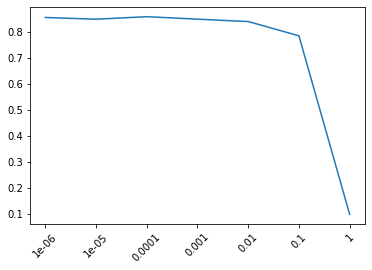

In [13]:
alpha_range = [10**k for k in range(-6, 1)]
print("Rango de 'alpha': %f - %.2f" % (np.array(alpha_range).min(), np.array(alpha_range).max()))
print("Mejor 'alpha' = %f" % (grid_search.best_params_['net__alpha']))
print("Mejor puntuación = %.3f" % (grid_search.best_score_))

plt.xticks(range(len(alpha_range)), alpha_range, rotation=45)
_ = plt.plot( grid_search.cv_results_['mean_test_score'])

## Validación cruzada

Con el mejor estimador obtenido en la búsqueda en rejilla

```cross_val_predict```

In [35]:
kfold = KFold(n_splits=5)

y_pred_cv = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=kfold)

In [36]:
print("Accuracy: %.3f\t" % (accuracy_score(y_train, y_pred_cv)))

Accuracy: 0.805	


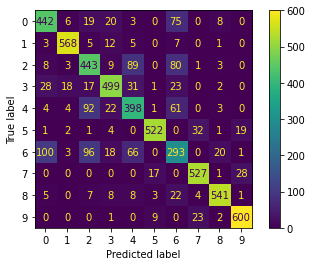

In [45]:
cm = confusion_matrix(y_train, y_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

## Validación con datos de test

In [46]:
net = myw.GluonClassifier(model_function=fashion_net, loss_function=loss,
                         batch_size=256, epochs=400, optimizer='adam',
                         alpha=1e-4, # el mejor alpha
                         verbose=False)
# alpha=grid_search.best_params_['net__alpha']
pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('net', net)])

In [47]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('std_sc', StandardScaler()),
                ('net',
                 GluonClassifier(alpha=0.0001, batch_size=256, epochs=400,
                                 loss_function=SoftmaxCrossEntropyLoss(batch_axis=0, w=None),
                                 model_function=<function fashion_net at 0x7f9164eca670>,
                                 optimizer='adam'))])

In [48]:
yp = pipe.predict(X_test)

In [49]:
print("Accuracy: %.3f\t" % (accuracy_score(y_test, yp)))

Accuracy: 0.859	


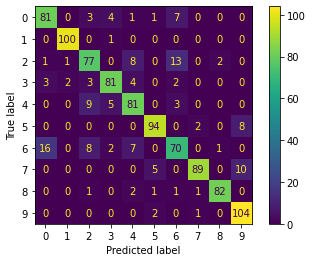

In [50]:
cm = confusion_matrix(y_test, yp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

# MLPClassifier de scikit-learn

In [23]:
kfold = KFold(n_splits=5)

net = MLPClassifier(hidden_layer_sizes=(784, 392,), solver='adam', max_iter=1000)

pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('net', net)])

In [24]:
l_alpha = [10.**k for k in range(-5, 5)]
grid_params = {'net__alpha': l_alpha} 


grid_search = GridSearchCV(pipe, grid_params, cv=kfold,
                           return_train_score=True,
                           n_jobs=4,
                           verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('std_sc', StandardScaler()),
                                       ('net',
                                        MLPClassifier(hidden_layer_sizes=(784,
                                                                          392),
                                                      max_iter=1000))]),
             n_jobs=4,
             param_grid={'net__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0,
                                        10.0, 100.0, 1000.0, 10000.0]},
             return_train_score=True, verbose=1)

Rango de 'alpha': 0.000010 - 10000.00
Mejor 'alpha' = 0.000010
Mejor puntuación = 0.855


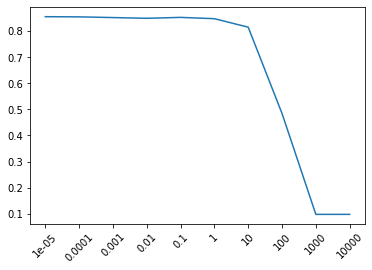

In [25]:
alpha_range = [10**k for k in range(-5, 5)]
print("Rango de 'alpha': %f - %.2f" % (np.array(alpha_range).min(), np.array(alpha_range).max()))
print("Mejor 'alpha' = %f" % (grid_search.best_params_['net__alpha']))
print("Mejor puntuación = %.3f" % (grid_search.best_score_))

plt.xticks(range(len(alpha_range)), alpha_range, rotation=45)
_ = plt.plot( grid_search.cv_results_['mean_test_score'])

## Validación cruzada

In [42]:
kfold = KFold(n_splits=5)

y_pred_cv = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=kfold)

In [43]:
print("Acc: %.3f\t" % (accuracy_score(y_train, y_pred_cv)))

Acc: 0.805	


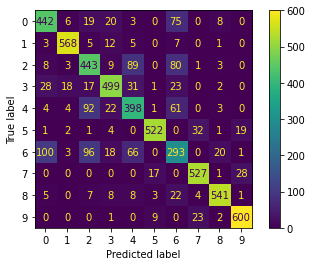

In [44]:
cm = confusion_matrix(y_train, y_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

## Validación con datos de test

In [51]:
kfold = KFold(n_splits=5)

net = MLPClassifier(hidden_layer_sizes=(784, 392,), solver='adam', max_iter=1000, alpha=1e-5)

pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('net', net)])

In [53]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('std_sc', StandardScaler()),
                ('net',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(784, 392),
                               max_iter=1000))])

In [54]:
yp = pipe.predict(X_test)

In [56]:
print("Acc: %.3f\t" % (accuracy_score(y_test, yp)))

Acc: 0.862	


In [ ]:
cm = confusion_matrix(y_test, yp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

# LogisticRegression de scikit-learn

In [29]:
from sklearn.linear_model import LogisticRegression

kfold = KFold(n_splits=5)

lr = LogisticRegression(max_iter=5000, multi_class='multinomial')

pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('lr', lr)])

In [30]:
l_C = [1.0 + (k*2) for k in range(0, 10)]
grid_params = {'lr__C': l_C} 


grid_search = GridSearchCV(pipe, grid_params, cv=kfold,
                           scoring='accuracy',
                           return_train_score=True,
                           n_jobs=4,
                           verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('std_sc', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='multinomial'))]),
             n_jobs=4,
             param_grid={'lr__C': [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0,
                                   17.0, 19.0]},
             return_train_score=True, scoring='accuracy', verbose=1)

Rango de 'C': 1.000000 - 39.00
Mejor 'C' = 1.000000
Mejor puntuación = 0.806


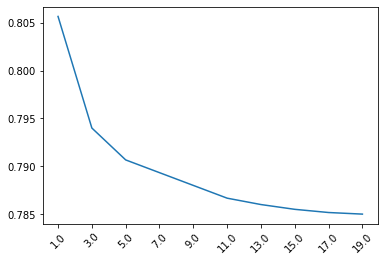

In [31]:
C_range = [1.0 + (k*2) for k in range(0, 20)]
print("Rango de 'C': %f - %.2f" % (np.array(C_range).min(), np.array(C_range).max()))
print("Mejor 'C' = %f" % (grid_search.best_params_['lr__C']))
print("Mejor puntuación = %.3f" % (grid_search.best_score_))

plt.xticks(range(len(C_range)), C_range, rotation=45)
_ = plt.plot(grid_search.cv_results_['mean_test_score'])

## Validación cruzada

In [38]:
y_pred_cv = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=kfold)

In [39]:
print("Acc: %.3f\t" % (accuracy_score(y_train, y_pred_cv)))

Acc: 0.805	


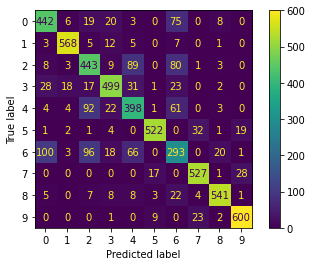

In [41]:
cm = confusion_matrix(y_train, y_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

## Validación con datos de test

In [58]:
from sklearn.linear_model import LogisticRegression

kfold = KFold(n_splits=5)

lr = LogisticRegression(max_iter=5000, multi_class='multinomial', C=1.0)

pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('lr', lr)])

In [59]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('std_sc', StandardScaler()),
                ('lr',
                 LogisticRegression(max_iter=5000, multi_class='multinomial'))])

In [60]:
yp = pipe.predict(X_test)

In [62]:
print("Acc: %.3f\t" % (accuracy_score(y_test, yp)))

Acc: 0.801	


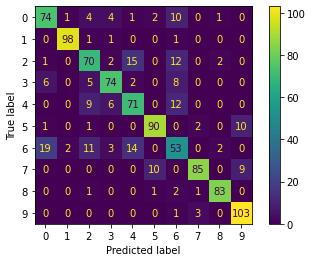

In [63]:
cm = confusion_matrix(y_test, yp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()